# Name - Arunangshu Borthakur
# Sapid - 500121923
# Rollno- R2142230588
# Batch - 4 - AIML

# Using pretrained ResNet-50

In [10]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = len(train_ds.classes)

# Load pretrained ResNet50
model = models.resnet50(weights="IMAGENET1K_V1")   # PyTorch 2.0 syntax
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

model = model.to(device)
print("Using ResNet-50 model")
print(model)

# Loss with class weights
criterion = nn.CrossEntropyLoss(weight=weights)

# AdamW optimizer + cosine LR
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-6)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 199MB/s] 


Using ResNet-50 model
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_si

# ResNet-50 Training Loop (AMP + early stopping)

In [12]:
import time, copy
from sklearn.metrics import f1_score, accuracy_score
from torch.cuda.amp import autocast, GradScaler

EPOCHS = 3
PATIENCE = 6
best_f1 = 0.0
scaler = GradScaler()
best_model_wts = copy.deepcopy(model.state_dict())
save_path = "/kaggle/working/best_resnet50.pth"

def evaluate(loader):
    model.eval()
    y_true, y_pred = [], []
    running_loss = 0.0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            out = model(imgs)
            loss = criterion(out, labels)
            running_loss += loss.item() * imgs.size(0)
            preds = out.argmax(dim=1).cpu().tolist()
            y_pred.extend(preds)
            y_true.extend(labels.cpu().tolist())
    avg_loss = running_loss / len(loader.dataset)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return avg_loss, acc, f1

no_improve = 0
for ep in range(1, EPOCHS+1):
    t0 = time.time()
    model.train()
    run_loss = 0.0
    
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        with autocast():
            out = model(imgs)
            loss = criterion(out, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        run_loss += loss.item() * imgs.size(0)
    
    scheduler.step()
    
    train_loss = run_loss / len(train_loader.dataset)
    val_loss, val_acc, val_f1 = evaluate(val_loader)
    
    print(f"Epoch {ep}/{EPOCHS}  train={train_loss:.4f}  val_acc={val_acc:.4f}  val_f1={val_f1:.4f}  time={time.time()-t0:.1f}s")
    
    if val_f1 > best_f1:
        best_f1 = val_f1
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save({'model_state_dict': best_model_wts, 'classes': train_ds.classes}, save_path)
        print("    ✔ Saved new best model")
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= PATIENCE:
            print("Early stopping triggered!")
            break

model.load_state_dict(best_model_wts)
print("Training completed — Best F1:", best_f1)


/tmp/ipykernel_48/3748217131.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_48/3748217131.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/3  train=0.6465  val_acc=0.7439  val_f1=0.7185  time=76.8s
    ✔ Saved new best model


/tmp/ipykernel_48/3748217131.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2/3  train=0.5460  val_acc=0.8045  val_f1=0.7656  time=70.5s
    ✔ Saved new best model


/tmp/ipykernel_48/3748217131.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3/3  train=0.4819  val_acc=0.8019  val_f1=0.7700  time=70.0s
    ✔ Saved new best model
Training completed — Best F1: 0.7699911597521942


# Test Evaluation for ResNet-50

In [15]:

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        out = model(imgs)
        preds = out.argmax(dim=1).cpu().tolist()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().tolist())

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=train_ds.classes, zero_division=0))

cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", cm)
print("Test Accuracy:", accuracy_score(y_true, y_pred))


Classification Report:

              precision    recall  f1-score   support

       beige       0.45      0.72      0.55        90
       black       0.84      0.89      0.86        87
        blue       0.98      0.92      0.95       159
       brown       0.78      0.83      0.80       121
        gold       0.41      0.67      0.50        45
       green       0.98      0.93      0.95       121
        grey       0.70      0.55      0.62        92
      orange       0.99      0.70      0.82       114
        pink       0.99      0.88      0.93       103
      purple       0.95      0.97      0.96       115
         red       0.84      0.98      0.90       136
      silver       0.70      0.48      0.57        77
         tan       0.50      0.31      0.39        86
       white       0.84      0.94      0.89        86
      yellow       0.90      0.91      0.91       124

    accuracy                           0.81      1556
   macro avg       0.79      0.78      0.77      1556
we

# Full Performance Visualization


=== Classification Report ===

              precision    recall  f1-score   support

       beige       0.45      0.72      0.55        90
       black       0.84      0.89      0.86        87
        blue       0.98      0.92      0.95       159
       brown       0.78      0.83      0.80       121
        gold       0.41      0.67      0.50        45
       green       0.98      0.93      0.95       121
        grey       0.70      0.55      0.62        92
      orange       0.99      0.70      0.82       114
        pink       0.99      0.88      0.93       103
      purple       0.95      0.97      0.96       115
         red       0.84      0.98      0.90       136
      silver       0.70      0.48      0.57        77
         tan       0.50      0.31      0.39        86
       white       0.84      0.94      0.89        86
      yellow       0.90      0.91      0.91       124

    accuracy                           0.81      1556
   macro avg       0.79      0.78      0.77     

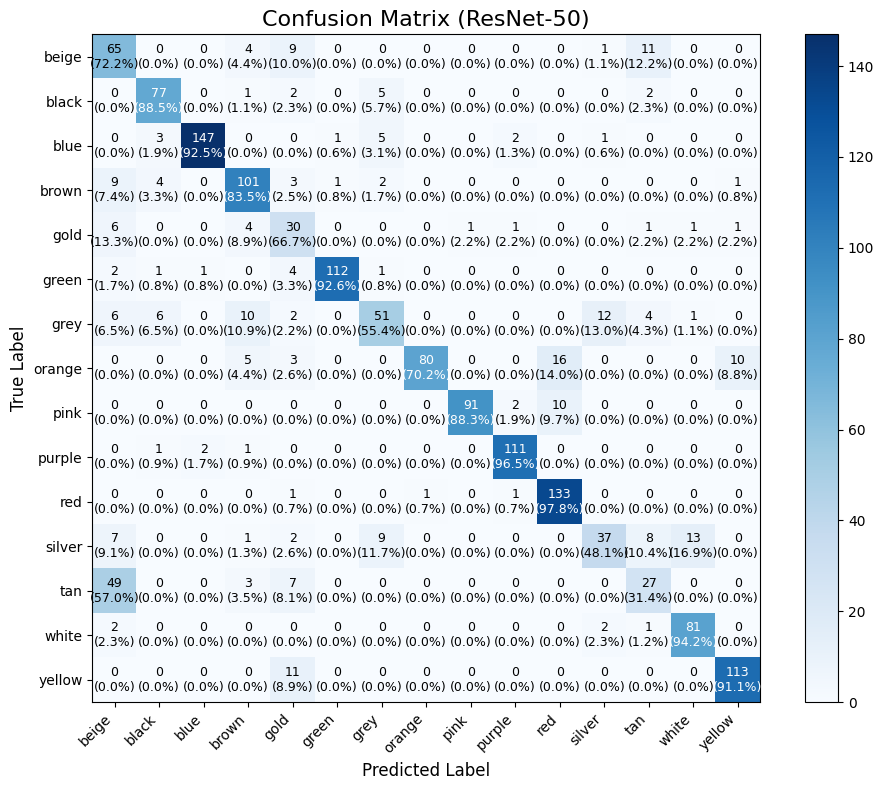

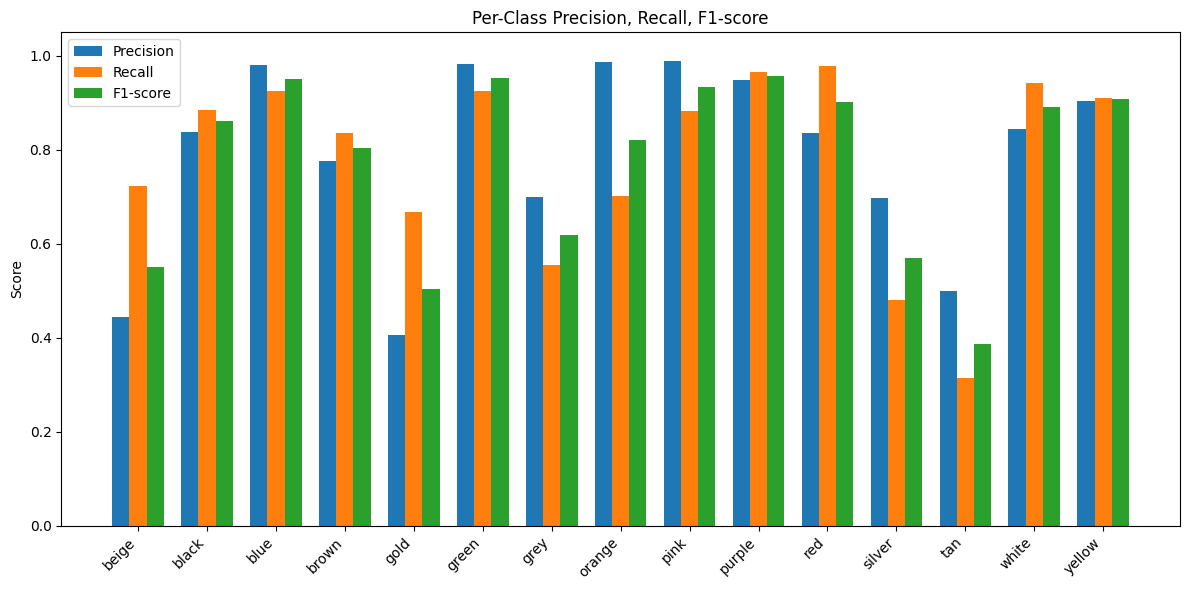


=== PERFORMANCE SUMMARY ===
Overall Accuracy: 0.8072
beige: Precision=0.445, Recall=0.722, F1=0.551
black: Precision=0.837, Recall=0.885, F1=0.860
blue: Precision=0.980, Recall=0.925, F1=0.951
brown: Precision=0.777, Recall=0.835, F1=0.805
gold: Precision=0.405, Recall=0.667, F1=0.504
green: Precision=0.982, Recall=0.926, F1=0.953
grey: Precision=0.699, Recall=0.554, F1=0.618
orange: Precision=0.988, Recall=0.702, F1=0.821
pink: Precision=0.989, Recall=0.883, F1=0.933
purple: Precision=0.949, Recall=0.965, F1=0.957
red: Precision=0.836, Recall=0.978, F1=0.902
silver: Precision=0.698, Recall=0.481, F1=0.569
tan: Precision=0.500, Recall=0.314, F1=0.386
white: Precision=0.844, Recall=0.942, F1=0.890
yellow: Precision=0.904, Recall=0.911, F1=0.908


In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# -------- 1. Classification Report --------
print("\n=== Classification Report ===\n")
report = classification_report(y_true, y_pred, target_names=train_ds.classes, output_dict=True, zero_division=0)
print(classification_report(y_true, y_pred, target_names=train_ds.classes, zero_division=0))

overall_accuracy = accuracy_score(y_true, y_pred)
print("\nOverall Test Accuracy:", overall_accuracy)

# Extract precision, recall, F1 for bar graph (per class)
class_names = train_ds.classes
precisions = [report[label]["precision"] for label in class_names]
recalls = [report[label]["recall"] for label in class_names]
f1s = [report[label]["f1-score"] for label in class_names]

# -------- 2. Confusion Matrix (heatmap) --------
cm = confusion_matrix(y_true, y_pred)
cm_list = cm.tolist()
num_classes = len(class_names)

fig, ax = plt.subplots(figsize=(10, 8))
heatmap = ax.imshow(cm_list, cmap="Blues")

ax.set_title("Confusion Matrix (ResNet-50)", fontsize=16)
ax.set_xlabel("Predicted Label", fontsize=12)
ax.set_ylabel("True Label", fontsize=12)

ax.set_xticks(range(num_classes))
ax.set_yticks(range(num_classes))
ax.set_xticklabels(class_names, rotation=45, ha="right")
ax.set_yticklabels(class_names)

plt.colorbar(heatmap)

max_value = max(max(row) for row in cm_list)

# Annotate cells (count + percentage)
for i in range(num_classes):
    row_sum = sum(cm_list[i]) or 1
    for j in range(num_classes):
        count = cm_list[i][j]
        percentage = (count / row_sum) * 100
        text_color = "white" if count > max_value * 0.5 else "black"
        ax.text(j, i, f"{count}\n({percentage:.1f}%)",
                ha="center", va="center", color=text_color, fontsize=9)

plt.tight_layout()
plt.show()


# -------- 3. Bar Charts for Precision, Recall, F1 --------
fig, ax = plt.subplots(figsize=(12, 6))
x = range(num_classes)

width = 0.25

# Plot bars
ax.bar([i - width for i in x], precisions, width=width, label='Precision')
ax.bar(x, recalls, width=width, label='Recall')
ax.bar([i + width for i in x], f1s, width=width, label='F1-score')

ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.set_ylabel("Score")
ax.set_ylim(0, 1.05)
ax.set_title("Per-Class Precision, Recall, F1-score")
ax.legend()

plt.tight_layout()
plt.show()


# -------- 4. Summary Print --------
print("\n=== PERFORMANCE SUMMARY ===")
print("Overall Accuracy:", round(overall_accuracy, 4))
for i, cls in enumerate(class_names):
    print(f"{cls}: Precision={precisions[i]:.3f}, Recall={recalls[i]:.3f}, F1={f1s[i]:.3f}")
